In [144]:
import numpy as np
import pandas as pd
import os

We have a problem regarding calculating player similarity. Games have different lengths and different amounts of players, it's not possible to compare them if they have irregular formats. Hence we are going to create embeddings for each player rich in information to "sumarize" their behaviour with other players and during the game.

In [145]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
max_rows = 0
max_columns = 0
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    max_rows = max(max_rows, game.shape[0])
    max_columns = max(max_columns, data.NUMBER_OF_PARTICIPANTS * 2 - 1)
max_rows, max_columns

(10710, np.int64(15))

We will fill the lack of information (due to a game being shorter or having less people) with zeros.

In [102]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
rows = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    inter_player_columns = game.columns[game.columns.str.match(f'P._TO_P.')]
    interaction_players = game[inter_player_columns].mean().mean()
    for id in range(1, data.NUMBER_OF_PARTICIPANTS+1):
        p1_looks = game.columns[game.columns.str.match(f'P{id}_TO_.[^{id}]')]
        p1_looked = game.columns[game.columns.str.match(f'P[^{id}]_TO_P{id}')]
        unpadded = game[[*p1_looks, *p1_looked]].values

        padded_array = np.zeros((max_rows, max_columns))
        padded_array[:unpadded.shape[0], :unpadded.shape[1]] = unpadded
        row = padded_array.flatten()
        
        rows.append(row)
        
df = pd.DataFrame(rows)

In [103]:
df

,0,1,2,3,4,5,6,7,8,9,...,160640,160641,160642,160643,160644,160645,160646,160647,160648,160649
0,0.534,0.046,0.083,0.000,0.041,0.029,0.067,0.023,0.030,0.049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.077,0.023,0.127,0.011,0.025,0.034,0.503,0.046,0.041,0.019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.079,0.030,0.041,0.039,0.041,0.037,0.533,0.083,0.127,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100,0.049,0.019,0.063,0.073,0.377,0.120,0.000,0.011,0.039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043,0.034,0.040,0.357,0.020,0.050,0.256,0.041,0.025,0.041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0.023,0.047,0.096,0.021,0.313,0.244,0.027,0.029,0.014,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.083,0.070,0.109,0.080,0.057,0.177,0.074,0.150,0.246,0.499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,0.037,0.039,0.031,0.066,0.126,0.374,0.053,0.074,0.056,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.004,0.048,0.079,0.049,0.024,0.059,0.519,0.019,0.064,0.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we create the model that will generate the embeddings.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(max_rows * max_columns,))

# Encoder
encoded = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(encoded)

# Embedding Layer
embedding = Dense(16, activation='relu', name='embedding')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(embedding)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(max_rows * max_columns, activation='linear')(decoded)

# Split into encoder and autoencoder models
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=embedding)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    df.values,
    df.values, 
    epochs=100, 
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Now we can use the encoder to generate embeddings for players
player_embeddings = encoder.predict(df.values)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160650)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │    10,281,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 160650)         │    10,442,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,729,562 (79.08 MB)

 Trainable params: 20,729,370 (79.08 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.1324 - val_loss: 0.0779
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0815 - val_loss: 0.0731
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0739 - val_loss: 0.0666
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0639 - val_loss: 0.0562
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0530 - val_loss: 0.0517
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0479 - val_loss: 0.0509
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0478 - val_loss: 0.0467
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0466 - val_loss: 0.0444
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0436 - val_loss: 0.0450
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0439 - val_loss: 0.0443
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0410 - val_loss: 0.0414
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1

In [112]:
player_embeddings

array([[0.24254787, 0.        , 0.        , ..., 0.        , 0.        ,
        0.07589349],
       [0.24119917, 0.        , 0.00260052, ..., 0.        , 0.        ,
        0.08661596],
       [0.00272461, 0.        , 0.8754123 , ..., 0.        , 0.        ,
        0.10181288],
       ...,
       [0.34546342, 0.        , 0.25737718, ..., 0.        , 0.07739319,
        0.13798174],
       [0.31665078, 0.        , 0.        , ..., 0.        , 0.        ,
        0.18148103],
       [0.43742684, 0.        , 0.04761263, ..., 0.        , 0.        ,
        0.2072477 ]], dtype=float32)

<Axes: ylabel='Frequency'>

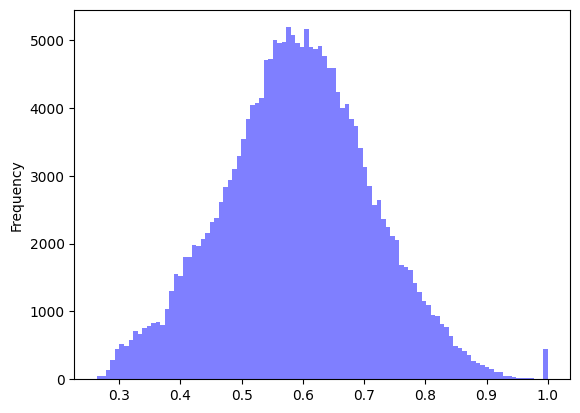

In [ ]:
from scipy.spatial.distance import pdist,squareform
similarities = 1/(1+squareform(pdist(player_embeddings, metric='euclidean')))
pd.Series(similarities.flatten()).plot.hist(bins=100, alpha=0.5, color='blue', label='Euclidean') 
# Tiene buena pinta

In [ ]:
# Quitamos similitudes con uno mismo
similarities[np.eye(similarities.shape[0], dtype=bool)] = 0
similarities

array([[0.        , 0.78848502, 0.30470801, ..., 0.59247351, 0.74546099,
        0.65910329],
       [0.78848502, 0.        , 0.32314673, ..., 0.58782517, 0.66044912,
        0.63052404],
       [0.30470801, 0.32314673, 0.        , ..., 0.34145064, 0.29510921,
        0.3088523 ],
       ...,
       [0.59247351, 0.58782517, 0.34145064, ..., 0.        , 0.60551172,
        0.67304259],
       [0.74546099, 0.66044912, 0.29510921, ..., 0.60551172, 0.        ,
        0.77242403],
       [0.65910329, 0.63052404, 0.3088523 , ..., 0.67304259, 0.77242403,
        0.        ]])

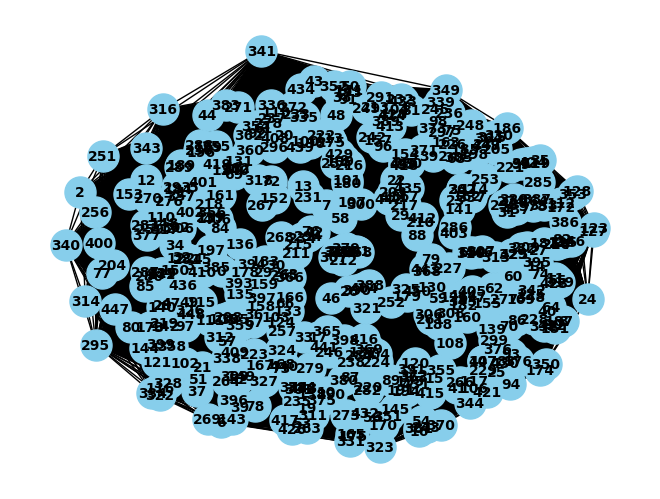

In [ ]:
import networkx as nx
G = nx.Graph(similarities)
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')

In [143]:
nx.write_gml(G, 'comm-f2f-Resistance/embeddings.gml')